### Import Library

In [1]:
import os
import tqdm
import torch
import numpy as np
import torchvision
import torch.nn as nn
from scipy import linalg
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

### DataLoader

In [2]:
class Data_downloader():
    def __init__(self, path_name, transform, batch_size) -> None:
        self.path_name = path_name
        self.transform = transform
        self.batch_size = batch_size

    def download_data(self):
        os.makedirs(self.path_name, exist_ok=True)
        dataset = datasets.MNIST(
            self.path_name, download=True, transform=self.transform
            )
        dataloader = DataLoader(
            dataset=dataset, batch_size=self.batch_size, shuffle=True
            )
        return dataloader

### initial weight for DCGAN

In [3]:
def init_weight(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

### Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, img_channels, model_name):
        super().__init__()
        self.model_name = model_name
        # DCGAN block
        def gen_block(in_channels, out_channels, kernal_size, stride, padding):
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, 
                    out_channels, 
                    kernal_size, 
                    stride, 
                    padding,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        self.models = {
            'GAN': nn.Sequential(
                nn.Linear(in_features=z_dim, out_features=256),
                nn.LeakyReLU(0.1),
                # in MNIST img_dim = 28*28 = 784
                nn.Linear(in_features=256, out_features=img_dim*img_dim),
                # output should between -1 and 1
                nn.Tanh(),
            ),
            'DCGAN': nn.Sequential(
                *gen_block(z_dim, 1024, 2, 1, 0), #->2*2
                *gen_block(1024, 512, 4, 2, 1), #->4*4
                *gen_block(512, 256, 4, 2, 1), #->8*8
                *gen_block(256, 128, 4, 2, 1), #->16*16
                nn.ConvTranspose2d(128, img_channels, 4, 2, 1), #->32*32
                nn.Tanh(),
            ),
            'WGAN': nn.Sequential(
                *gen_block(z_dim, 1024, 2, 1, 0), #->2*2
                *gen_block(1024, 512, 4, 2, 1), #->4*4
                *gen_block(512, 256, 4, 2, 1), #->8*8
                *gen_block(256, 128, 4, 2, 1), #->16*16
                nn.ConvTranspose2d(128, img_channels, 4, 2, 1), #->32*32
                nn.Tanh(),
            )
        }
    
    def forward(self, x):
        return self.models[self.model_name](x)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, img_channels, model_name):
        super().__init__()
        self.model_name = model_name
        # DCGAN block
        def disc_block(in_channels, out_channels, kernal_size, stride, padding):
            return nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernal_size, 
                    stride, 
                    padding, 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            )
        
        self.models = {
            'GAN': nn.Sequential(
                nn.Linear(in_features=img_dim*img_dim, out_features=128),
                nn.LeakyReLU(0.1),
                # the out_features is 1 because we only need to output
                # single value, ex: fake is 0, real is 1
                nn.Linear(in_features=128, out_features=1), 
                nn.Sigmoid(),
            ),
            'DCGAN': nn.Sequential(
                # Input: N * channels * 32 * 32
                nn.Conv2d(img_channels, 64, 4, 2, 1), #-> 16*16
                nn.LeakyReLU(0.2),
                *disc_block(64, 128, 4, 2, 1), #-> 8*8
                *disc_block(128, 256, 4, 2, 1), #-> 4*4
                *disc_block(256, 512, 4, 2, 1), #-> 2*2
                nn.Conv2d(512, 1, 2, 2, 0), # 1*1
                nn.Sigmoid(),
            ),
            'WGAN':nn.Sequential(
                # Input: N * channels * 32 * 32
                nn.Conv2d(img_channels, 64, 4, 2, 1), #-> 16*16
                nn.LeakyReLU(0.2),
                *disc_block(64, 128, 4, 2, 1), #-> 8*8
                *disc_block(128, 256, 4, 2, 1), #-> 4*4
                *disc_block(256, 512, 4, 2, 1), #-> 2*2
                nn.Conv2d(512, 1, 2, 2, 0), # 1*1
            )
        }
        
    def forward(self, x):
        return self.models[self.model_name](x)
        

### Plot training loss 

In [6]:
def plot_loss(model_name, **kwargs):
    # fix image size
    fig = plt.figure(figsize=(10, 6))
    plt.title(f"{model_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # plot loss
    for label, data in kwargs.items():
        plt.plot(
            range(1, len(data)+1), data,
            label=label
        )
    # plot legend box
    plt.legend(
        loc='lower right',
        fancybox=True, shadow=True
    )

    plt.show()
    
    return fig

### FID metric


In [7]:
class PartialInceptionNetwork(nn.Module):

    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

    def forward(self, x):
        """
        Args:
            x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
        Returns:
            inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
        """
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)
        x = x * 2 -1 # Normalize to [-1, 1]

        # Trigger output hook
        self.inception_network(x)

        # Output: N x 2048 x 1 x 1 
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations

In [8]:
def compute_FID(real_img, fake_img, opts):
    # input: N_channels * 1 * 28 * 28
    if opts['model_name'] == 'GAN':
        real_img = real_img.reshape(-1, 1, 28, 28)

    inception_v3(pretrained=True).to(opts['device'])
    img_transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    real_img = img_transform(real_img)
    fake_img = img_transform(fake_img)
    
    # print(np.shape(real_img))
    # print(np.shape(fake_img))

    # get the activations
    def compute_act_mean_std(images, batch_size=1):
        num_images = images.shape[0]
        inception_network = PartialInceptionNetwork().to(opts['device'])
        inception_network.eval()
        n_batches = int(np.ceil(num_images  / batch_size))
        act = np.zeros((num_images, 2048), dtype=np.float32)
        for batch_idx in range(n_batches):
            start_idx = batch_size * batch_idx
            end_idx = batch_size * (batch_idx + 1)

            imgs = images[start_idx:end_idx].to(opts['device'])
            activations = inception_network(imgs)
            activations = activations.detach().cpu().numpy()
            act[start_idx:end_idx, :] = activations

        mu = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return mu, sigma

    mu_act1, sigma_act1 = compute_act_mean_std(real_img)
    mu_act2, sigma_act2 = compute_act_mean_std(fake_img)

    # compute FID
    def compute_FD(mu1, mu2, sigma1, sigma2,eps=1e-6):
        mu1 = np.atleast_1d(mu1)
        mu2 = np.atleast_1d(mu2)
        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(sigma2)

        diff = mu1 - mu2

        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                   'adding %s to diagonal of cov estimates') % eps
            print(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)

        FID = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

        return FID

    FID = compute_FD(mu_act1, mu_act2, sigma_act1, sigma_act2)
    
    return FID

### Training

In [9]:
def GAN_training(data_load, model, opts): 
    progress = tqdm.tqdm(total=opts['epochs'])
    loss_all = {'G_loss': [], 'D_loss':[]}
    FID_all = []
    for epoch in range(1, opts['epochs']+1):
        for batch_idx, (img, label) in enumerate(data_load):
            if opts['model_name'] == 'GAN':
                # 32*1*28*28 to 32*784
                img = img.view(-1, 784).to(opts['device'])
                noise = torch.randn((opts['batch_size'], opts['z_dim'])).to(opts['device'])
            elif opts['model_name'] == 'DCGAN':
                img = img.to(opts['device'])
                noise = torch.randn((opts['batch_size'], opts['z_dim'], 1, 1)).to(opts['device'])
            else:
                img = img.to(opts['device'])

            for _ in range(opts['critic_iteration']):
                if opts['model_name'] == 'WGAN':
                    noise = torch.randn((opts['batch_size'], opts['z_dim'], 1, 1)).to(opts['device'])
                # 高斯distribution
                # Train Discriminator: max(E log(D(img)) + E log(1-D(G(z))))
                # G(z)
                fake_img = model['G'](noise)
                # D(img), D(G(z))
                D_real_img = model['D'](img).view(-1)
                D_fake_img = model['D'](fake_img).view(-1)
                if opts['model_name'] == 'WGAN':
                    loss_D = -(torch.mean(D_real_img) - torch.mean(D_fake_img))
                else:
                # log(D(img)), log(1-D(G(z)))
                    loss_D_real = opts['criterion'](D_real_img, torch.ones_like(D_real_img))
                    loss_D_fake = opts['criterion'](D_fake_img, torch.zeros_like(D_fake_img))
                    loss_D = (loss_D_real + loss_D_fake) / 2

                model['D'].zero_grad()
                loss_D.backward(retain_graph=True)
                model['optim_D'].step()
                
                if opts['model_name'] == 'WGAN':
                    for p in model['D'].parameters():
                        p.data.clamp_(-opts['weight_clip'], opts['weight_clip'])

            # Train Generator max(log(D(G(z)))
            output = model['D'](fake_img).view(-1)
            if opts['model_name'] == 'WGAN':
                loss_G = -torch.mean(output)
            else:
                loss_G = opts['criterion'](output, torch.ones_like(output))

            model['G'].zero_grad()
            loss_G.backward()
            model['optim_G'].step()
            
        
            if batch_idx == len(data_load) - 2:
                with torch.no_grad():
                    loss_all['G_loss'] += [loss_G.cpu().data.numpy()]
                    loss_all['D_loss'] += [loss_D.cpu().data.numpy()]
#                     clear_output(wait=True)
#                     plot_loss(opts['model_name'], **loss_all)

                    if epoch % (opts['epochs']/5) == 0:
                        progress.update(opts['epochs']/5)
                        print(f"Epoch: [{epoch}/{opts['epochs']}], G_Loss: [{loss_G: .4f}], D_Loss: [{loss_D: .4f}]")
                
                        fake_img = model['G'](model['fixed_noise'])

                        if opts['model_name'] == 'GAN':
                            fake_img = fake_img.reshape(-1, 1, 28, 28)
                        else:
                            # 128*1*32*32 -> 128*1*28*28
                            trans = transforms.Compose([transforms.Resize((28, 28))])
                            fake_img = trans(fake_img)

                        FID = compute_FID(img, fake_img, opts)
                        FID_all += [FID]
                        print(f"Epoch: [{epoch}/{opts['epochs']}], FID: [{FID}]")


                        if epoch == opts['epochs']:
                            plot_loss(opts['model_name'], **loss_all)
                            fake_img_grid = torchvision.utils.make_grid(fake_img[:25], nrow=5, normalize=True)
                            plt.imshow(fake_img_grid.permute(1, 2, 0).cpu().data.numpy())
                            plt.show()

### Main Function

 20%|██        | 8.0/40 [01:35<06:21, 11.93s/it]

Epoch: [8/40], G_Loss: [ 1.2570], D_Loss: [ 0.4383]
Epoch: [8/40], FID: [73.89679776356667]


 40%|████      | 16.0/40 [03:18<04:58, 12.46s/it]

Epoch: [16/40], G_Loss: [ 1.2397], D_Loss: [ 0.5393]
Epoch: [16/40], FID: [41.33762132900658]


 60%|██████    | 24.0/40 [04:59<03:21, 12.57s/it]

Epoch: [24/40], G_Loss: [ 0.8510], D_Loss: [ 0.7307]
Epoch: [24/40], FID: [38.421761695378436]


 80%|████████  | 32.0/40 [06:42<01:41, 12.70s/it]

Epoch: [32/40], G_Loss: [ 1.1656], D_Loss: [ 0.6058]
Epoch: [32/40], FID: [49.8055104065037]


100%|██████████| 40.0/40 [08:27<00:00, 12.82s/it]

Epoch: [40/40], G_Loss: [ 0.9275], D_Loss: [ 0.7313]
Epoch: [40/40], FID: [38.257972511136785]


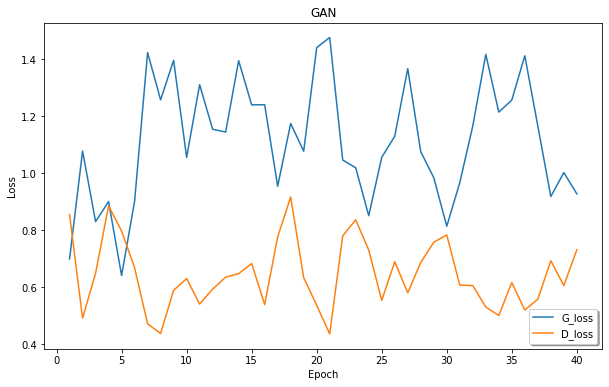

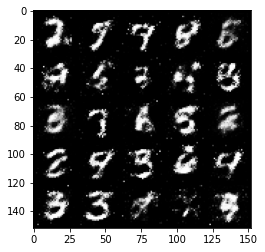

100%|██████████| 40.0/40 [08:33<00:00, 12.84s/it]
 20%|██        | 2.0/10 [00:24<01:38, 12.27s/it]

Epoch: [2/10], G_Loss: [ 2.8259], D_Loss: [ 0.1760]
Epoch: [2/10], FID: [42.545046705158285]


 40%|████      | 4.0/10 [00:57<01:27, 14.63s/it]

Epoch: [4/10], G_Loss: [ 2.2293], D_Loss: [ 0.3672]
Epoch: [4/10], FID: [17.30541305171785]


 60%|██████    | 6.0/10 [01:29<01:01, 15.38s/it]

Epoch: [6/10], G_Loss: [ 1.1425], D_Loss: [ 0.3642]
Epoch: [6/10], FID: [14.393520691479608]


 80%|████████  | 8.0/10 [02:02<00:31, 15.82s/it]

Epoch: [8/10], G_Loss: [ 2.8901], D_Loss: [ 0.2656]
Epoch: [8/10], FID: [11.89991870919171]


100%|██████████| 10.0/10 [02:35<00:00, 16.06s/it]

Epoch: [10/10], G_Loss: [ 3.4034], D_Loss: [ 0.0991]
Epoch: [10/10], FID: [13.95415268451876]


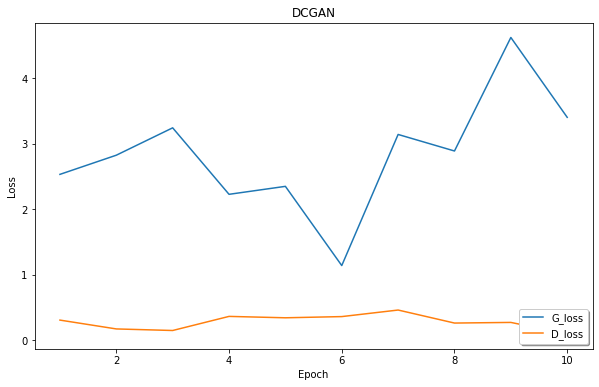

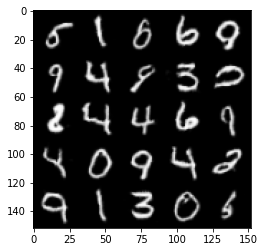

100%|██████████| 10.0/10 [02:44<00:00, 16.44s/it]
 20%|██        | 2.0/10 [02:18<09:12, 69.10s/it]

Epoch: [2/10], G_Loss: [ 0.1959], D_Loss: [-0.3802]
Epoch: [2/10], FID: [102.26223256804178]


 40%|████      | 4.0/10 [04:43<07:06, 71.12s/it]

Epoch: [4/10], G_Loss: [ 0.1763], D_Loss: [-0.3033]
Epoch: [4/10], FID: [30.871614589930147]


 60%|██████    | 6.0/10 [07:07<04:46, 71.59s/it]

Epoch: [6/10], G_Loss: [ 0.1818], D_Loss: [-0.3509]
Epoch: [6/10], FID: [22.637909987900713]


 80%|████████  | 8.0/10 [09:31<02:23, 71.80s/it]

Epoch: [8/10], G_Loss: [ 0.1810], D_Loss: [-0.3503]
Epoch: [8/10], FID: [27.031141721562264]


100%|██████████| 10.0/10 [11:56<00:00, 72.06s/it]

Epoch: [10/10], G_Loss: [ 0.1821], D_Loss: [-0.3535]
Epoch: [10/10], FID: [29.272094260997974]


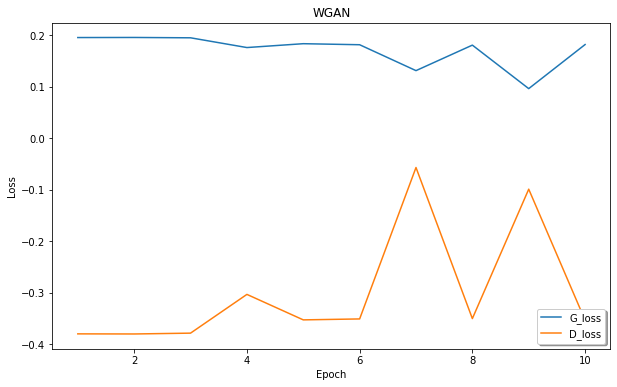

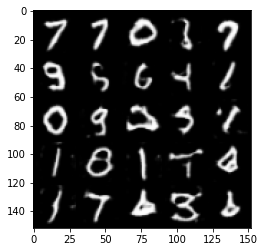

100%|██████████| 10.0/10 [12:03<00:00, 72.36s/it]


In [10]:
if __name__ == '__main__':
    # Hyperparameters of our GANs
    hyper_param = {'GAN': {}, 'DCGAN':{}, 'WGAN':{}}
    
    hyper_param['GAN'] = {
        'lr': 3e-4,
        'betas': (0.9, 0.999),
        'z_dim': 64,
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'epochs': 40,
        'img_size': 28,
        'criterion': nn.BCELoss(),
        'batch_size': 32,
        'model_name': 'GAN',
        'img_channel': 1,
        'critic_iteration': 1,
    }

    hyper_param['DCGAN'] = {
        'lr': 2e-4,
        'betas': (0.5, 0.999),
        'z_dim': 100,
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'epochs': 10,
        'img_size': 32,
        'criterion': nn.BCELoss(),
        'batch_size': 128,
        'model_name': 'DCGAN',
        'img_channel': 1,
        'critic_iteration': 1,
    }

    hyper_param['WGAN'] = {
        'lr': 5e-5,
        'betas': None,
        'z_dim': 100,
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'epochs': 10,
        'img_size': 32,
        'criterion': nn.BCELoss(),
        'batch_size': 32,
        'model_name': 'WGAN',
        'img_channel': 1,
        'weight_clip': 0.01,
        'critic_iteration': 5,
    }

    for model_name in hyper_param:
        h_p = hyper_param[model_name]
        # load data with batch size and different init size
        transform = transforms.Compose([
            transforms.Resize((h_p['img_size'], h_p['img_size'])), 
            transforms.ToTensor(), 
            transforms.Normalize((0.5,), (0.5,))
        ])
        data_load = Data_downloader("MNIST_dataset", transform, h_p['batch_size']).download_data()
        # set up generator and discriminator and there optimizer
        G = Generator(h_p['z_dim'], h_p['img_size'], h_p['img_channel'], model_name).models[model_name].to(h_p['device'])
        D = Discriminator(h_p['img_size'], h_p['img_channel'], model_name).models[model_name].to(h_p['device'])
        
        if model_name != 'GAN':
            init_weight(G)
            init_weight(D)    
        if model_name != 'WGAN':
            optim_G = optim.Adam(G.parameters(), lr=h_p['lr'], betas=h_p['betas'])
            optim_D = optim.Adam(D.parameters(), lr=h_p['lr'], betas=h_p['betas'])
        else:
            optim_G = optim.RMSprop(G.parameters(), lr=h_p['lr'])
            optim_D = optim.RMSprop(D.parameters(), lr=h_p['lr'])

        # set up fixed noise
        if model_name != 'GAN':
            fixed_noise = torch.randn(h_p['batch_size'], h_p['z_dim'], 1, 1).to(h_p['device'])
        else:
            fixed_noise = torch.randn(h_p['batch_size'], h_p['z_dim']).to(h_p['device'])
        # set G D to train
        G.train()
        D.train()
    
        model = {
            'G': G,
            'D': D,
            'optim_G': optim_G,
            'optim_D': optim_D,
            'fixed_noise': fixed_noise
        }
        
        GAN_training(data_load, model, h_p)

### Report
  
#### Procedures:
我建構了三個model分別為全連接的linear GAN、DCGAN、WGAN，第一個我參考了網路上的結果來設計model和hyperparameter以達到快速收斂，後兩者我參考了他們的原始論文，並根據我們的資料集MNIST去做一些調整，由於MNIST的圖片size是28而在原始論文中的img size是64的，為了不讓原始圖片放大太多，我把他設計成32，但也根據原始架構使每一層conv block過後的size變為原本的1/2，最後結果看起來也是相當不錯的。最後就是去metric我們的結果，我利用pretrain的inception_v3 model來比對real img和generate img的distrubution，結果越小越好。
#### Discussion:
本次作業感覺由於dataset太簡單了，所以基本上都會跑出我肉眼上覺得很像的結果，不過第一個GAN model由於只是接Linear所以要20多個epoch後才有好的結果，其餘兩個皆可在5個epoch左右就有很不錯的結果。本次作業我覺得最難的地方是做FID，不是很清楚把東西餵進inception的Model後他要怎麼跑才能拿來算FD，所以尋找了很多網路上的範例，最後很幸運的結果越好時，FID也有下降。結果中我發現GAN我跑了40 epoch，DCGAN跑了10 epoch，WGAN跑了10 epoch，他們的FID就會有較低的結果，且繼續跑反而可能使FID上升。